## Model Data

In [185]:
# Import Libraries
import numpy             as np 
import pandas            as pd 
import matplotlib.pyplot as plt
import seaborn           as sns

In [300]:
# Load data
data = pd.read_csv('../../cross_sell_clean2.csv')

Convert days_to_activation to weeks_to_activation

In [301]:
# Cap Outliers
data.loc[data['days_to_activation'] > 150, 'days_to_activation'] = 150

# Convert from days to weeks
data['weeks_to_activation'] = data['days_to_activation']/7

In [305]:
# Remove irregular years
data = data[data['orderyear'] != 1900]
data = data[data['orderyear'] != 2012]

## Feature Selection

In [306]:
columns = [  'xseller',
             'orderyear',
             'ordermonth',     
             'regtenure',
             'customer_type_group',
             'weeks_to_activation',
             'weekstogetresult_grp',
             'traffic_source',
             'kits_ordered',
             'kit_activation_rate',
             'kit_completion_rate'
]

model_data = data[columns]

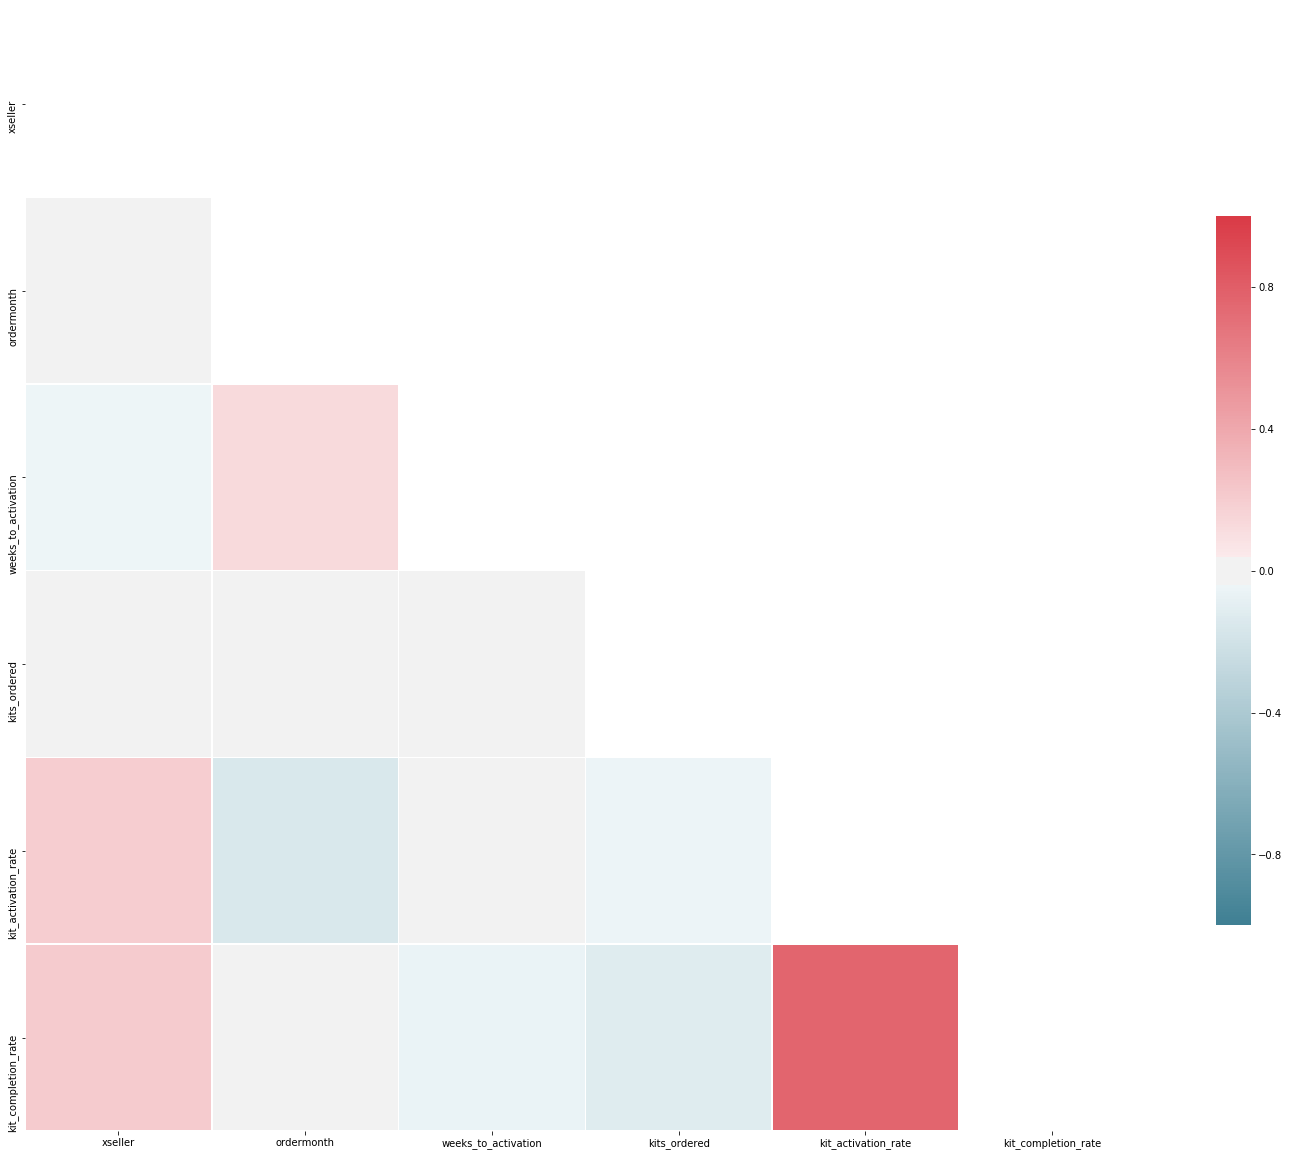

In [294]:
# Plot Correlation Matrix

# Generate and visualize the correlation matrix
corr = model_data.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

plt.tight_layout()

In [307]:
# Prepare data for modeling
pd.options.mode.chained_assignment = None

# weekstogetresult_grp : convert to numeric
model_data['weekstogetresult_grp'] = model_data['weekstogetresult_grp'].replace('>10s', '12')
model_data['weekstogetresult_grp'] = pd.to_numeric(model_data['weekstogetresult_grp'])

# regtenure : convert to numeric
model_data['regtenure'] = model_data['regtenure'].str.replace('<=', '')
model_data['regtenure'].replace('>120', '150',  inplace=True)
model_data['regtenure'] = pd.to_numeric(model_data['regtenure'])

# customer_type_group to binary
# Existing Reg = 1, New Reg = 0
model_data['customer_type_group'] = (model_data['customer_type_group'] == 'Existing Reg').astype('int')

# year, month, and traffic_source dummy variables
model_data = pd.get_dummies(model_data, columns=['orderyear', 'ordermonth'], drop_first=True)
#model_data = pd.get_dummies(model_data, columns=['ordermonth'], drop_first=True)
model_data = pd.get_dummies(model_data, columns=['traffic_source'])
model_data.drop('traffic_source_unknown', axis=1, inplace=True)

## Run Model

In [331]:
# Create training data
X = model_data.drop('xseller', axis=1)
y = model_data['xseller']

In [332]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

Scikit-Learn

In [333]:
## Logistic Model Pipeline
from sklearn.pipeline      import Pipeline, make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble      import RandomForestClassifier

# L1 Logistic
log_pipeline = Pipeline(memory=None,
                        steps = [('imputer'   , Imputer(missing_values='NaN', strategy='median', axis=0)),
                                 ('classifier', LogisticRegression(class_weight='balanced', penalty="l2", C=1))]
                       )

             precision    recall  f1-score   support

          0       0.91      0.50      0.64     37152
          1       0.26      0.77      0.39      8518

avg / total       0.79      0.55      0.60     45670

ROC AUC: 0.68


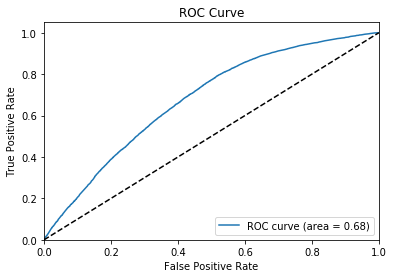

,feature,odds_ratio
0,regtenure,1.003159
1,customer_type_group,0.905190
2,weeks_to_activation,0.976679
3,weekstogetresult_grp,0.990640
4,kits_ordered,0.986844
5,kit_activation_rate,2.908374
6,kit_completion_rate,1.388758
7,orderyear_2014.0,0.891397
8,orderyear_2015.0,0.848892
9,orderyear_2016.0,0.806650


In [334]:
# Run Logistic Pipeline - large_core_data
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from visualizations import plot_roc

log_pipeline.fit(X_train, y_train)
log_predictions = log_pipeline.predict(X_test)

# Print Precision & Recall
print(classification_report(y_test, log_predictions))

# Print ROC Curve
plot_roc(y_test, log_pipeline.predict_proba(X_test))

# Print Feature Coefficients
classifier = log_pipeline.named_steps['classifier']
coef = classifier.coef_[0]
odds = np.exp(coef)

feature_names = X.columns.values.tolist()
feature_odds_data = pd.DataFrame({'feature': feature_names, 'odds_ratio': odds})
feature_odds_data

Stats Models

In [239]:
# Impute missing values
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_statsmodel = imp.fit_transform(X)

In [240]:
# Statsmodel
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit = sm.Logit(y, X_statsmodel)

# fit the model
result = logit.fit()

result.summary()
#np.exp(result.params)

Optimization terminated successfully.
         Current function value: 0.449433
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                xseller   No. Observations:               152804
Model:                          Logit   Df Residuals:                   152769
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Mar 2018   Pseudo R-squ.:                 0.06759
Time:                        22:38:47   Log-Likelihood:                -68675.
converged:                       True   LL-Null:                       -73654.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0031      0.000     12.394      0.000       0.003       0.004
x2            -0.1023      0.037     -2.730      0.006      -0.176      -0.029
x3            -0.0273      0.002    -13.772      0.000      -0.031      -0.023
x4            -0.0108      0.004     -2.436      0.015      -0.019      -0.002
x5            -0.0662      0.024     -2.788      0.005      -0.113      -0.020
x6             1.0887      0.030     36.490      0.000       1.030       1.147
x7             0.2670      0.027      9.876      0.000       0.214       0.320
x8            -2.0624      0.057    -36.266      0.000      -2.174      -1.951
x9            -2.2257      0.050    -44.094      0.000      -2.325      -2.127
x10           -2.2606      0.051    -44.505      0.000      -2.360      -2.161
x11           -2.3176      0.051    -45.365      0.000      -2.418      -2.217
x12           -2.8138      0.053    -53.076      0.000      -2.918      -2.710
x13           -0.0681      0.035     -1.962      0.050      -0.136   -7.47e-05
x14           -0.3067      0.032     -9.609      0.000      -0.369      -0.244
x15           -0.2812      0.037     -7.668      0.000      -0.353      -0.209
x16           -0.2381      0.041     -5.840      0.000      -0.318      -0.158
x17           -0.2726      0.038     -7.159      0.000      -0.347      -0.198
x18           -0.1750      0.037     -4.753      0.000      -0.247      -0.103
x19           -0.2337      0.036     -6.456      0.000      -0.305      -0.163
x20           -0.2553      0.040     -6.400      0.000      -0.333      -0.177
x21           -0.2959      0.037     -7.994      0.000      -0.368      -0.223
x22           -0.2422      0.030     -7.945      0.000      -0.302      -0.182
x23           -0.3344      0.031    -10.633      0.000      -0.396      -0.273
x24            0.1200      0.053      2.265      0.023       0.016       0.224
x25            0.7093      0.097      7.319      0.000       0.519       0.899
x26            0.3933      0.081      4.869      0.000       0.235       0.552
x27            0.2302      0.025      9.244      0.000       0.181       0.279
x28            0.1365      0.029      4.669      0.000       0.079       0.194
x29            0.2495      0.046      5.418      0.000       0.159       0.340
x30            0.2027      0.105      1.926      0.054      -0.004       0.409
x31            0.1689      0.037      4.608      0.000       0.097       0.241
x32            0.1686      0.029      5.719      0.000       0.111       0.226
x33            0.0870      0.072      1.214      0.225      -0.053       0.228
x34            0.1202      0.025      4.839      0.000       0.072       0.169
x35            0.5612      0.165      3.409      0.001       0.239       0.884
==============================================================================
"""

Predicting Activation Rates

In [278]:
# Create training data
X1 = model_data.drop(columns=['xseller', 'kit_activation_rate', 'kit_completion_rate', 'weeks_to_activation', 'weekstogetresult_grp'])
y1 = model_data
y1.loc[y1['kit_activation_rate'] > 0, 'kit_activation_rate'] = 1 
y1 = y1['kit_activation_rate']

In [279]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=40)

             precision    recall  f1-score   support

        0.0       0.43      0.57      0.49      9290
        1.0       0.78      0.67      0.72     21271

avg / total       0.67      0.64      0.65     30561

ROC AUC: 0.67


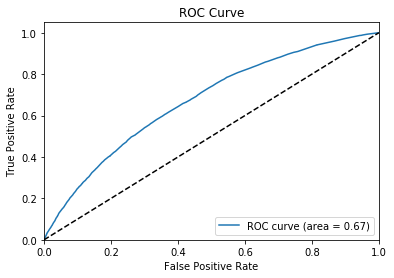

,feature,odds_ratio
0,regtenure,1.004522
1,customer_type_group,0.844733
2,kits_ordered,1.795404
3,ordermonth_2.0,0.917513
4,ordermonth_3.0,0.543857
5,ordermonth_4.0,0.996105
6,ordermonth_5.0,1.013901
7,ordermonth_6.0,0.780813
8,ordermonth_7.0,1.216089
9,ordermonth_8.0,1.236975


In [280]:
# Run Logistic Pipeline - large_core_data
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from visualizations import plot_roc

log_pipeline.fit(X_train1, y_train1)
log_predictions = log_pipeline.predict(X_test1)

# Print Precision & Recall
print(classification_report(y_test1, log_predictions))

# Print ROC Curve
plot_roc(y_test1, log_pipeline.predict_proba(X_test1))

# Print Feature Coefficients
classifier = log_pipeline.named_steps['classifier']
coef = classifier.coef_[0]
odds = np.exp(coef)

feature_names = X1.columns.values.tolist()
feature_odds_data = pd.DataFrame({'feature': feature_names, 'odds_ratio': odds})
feature_odds_data